Ömer Dikyol
2020702002

# Import Libraries and Dataset's CSV file

In [ ]:
#  This code installs the 'optuna' package using pip. optuna is a hyperparameter optimization framework.
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import optuna

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving weatherAUS.csv to weatherAUS.csv


In [ ]:
import io
weather_data = pd.read_csv('weatherAUS.csv')

# Analyze and Inspect Data

In [ ]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
weather_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
weather_data.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [ ]:
corr = weather_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-8-cf9c634d93c3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = weather_data.corr()
<ipython-input-8-cf9c634d93c3>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MinTemp,1.00,0.74,0.10,0.47,0.07,0.18,0.18,0.18,-0.23,0.01,-0.45,-0.46,0.08,0.02,0.90,0.71
MaxTemp,0.74,1.00,-0.07,0.59,0.47,0.07,0.01,0.05,-0.50,-0.51,-0.33,-0.43,-0.29,-0.28,0.89,0.98
Rainfall,0.10,-0.07,1.00,-0.06,-0.23,0.13,0.09,0.06,0.22,0.26,-0.17,-0.13,0.20,0.17,0.01,-0.08
Evaporation,0.47,0.59,-0.06,1.00,0.37,0.20,0.19,0.13,-0.50,-0.39,-0.27,-0.29,-0.18,-0.18,0.55,0.57
Sunshine,0.07,0.47,-0.23,0.37,1.00,-0.03,0.01,0.05,-0.49,-0.63,0.04,-0.02,-0.68,-0.70,0.29,0.49
WindGustSpeed,0.18,0.07,0.13,0.20,-0.03,1.00,0.61,0.69,-0.22,-0.03,-0.46,-0.41,0.07,0.11,0.15,0.03
WindSpeed9am,0.18,0.01,0.09,0.19,0.01,0.61,1.00,0.52,-0.27,-0.03,-0.23,-0.18,0.03,0.05,0.13,0.00
WindSpeed3pm,0.18,0.05,0.06,0.13,0.05,0.69,0.52,1.00,-0.15,0.02,-0.30,-0.26,0.05,0.03,0.16,0.03
Humidity9am,-0.23,-0.50,0.22,-0.50,-0.49,-0.22,-0.27,-0.15,1.00,0.67,0.14,0.19,0.45,0.36,-0.47,-0.50
Humidity3pm,0.01,-0.51,0.26,-0.39,-0.63,-0.03,-0.03,0.02,0.67,1.00,-0.03,0.05,0.52,0.52,-0.22,-0.56


# Question:
Can we predict whether it will rain tomorrow based on today's weather observations?

# Data Preparation and Cleaning

Categorize cities as northern and southern regions

In [ ]:
northern_region_cities = ['Cairns', 'Townsville', 'Darwin', 'Katherine','Uluru','Brisbane','Gold Coast','Perth','Alice Springs','Adelaide','Mount Gambier','Nuriootpa','Woomera']
southern_region_cities = [city for city in weather_data['Location'].unique() if city not in northern_region_cities]

Converting 'Date' column to datetime object


In [ ]:
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

Determining whether it is a rainy season based on the month in date

In [ ]:
def is_rainy_season(date, location):
    if location in northern_region_cities:
        # November to April is rainy season in the northern region
        return 1 if date.month in [11, 12, 1, 2, 3, 4] else 0
    else:
        # Southern regions might have different rainy seasons
        return 1 if date.month in [6, 7, 8] else 0

weather_data['IsRainySeason'] = weather_data.apply(lambda row: is_rainy_season(row['Date'], row['Location']), axis=1)

Calculating the average rainfall for each location



In [ ]:
# We will use the average rainfall for each city as a feature to train our model
rainy_cities_info = weather_data.groupby('Location')['Rainfall'].mean()
weather_data['RaininessScore'] = weather_data['Location'].map(rainy_cities_info)

Dropping columns with more than 30% missing values

In [ ]:
columns_to_drop = weather_data.columns[weather_data.isnull().mean() > 0.3]
weather_data_cleaned = weather_data.drop(columns=columns_to_drop)

Filling missing values for numerical columns with their mean

In [ ]:
numerical_cols = weather_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
weather_data_cleaned[numerical_cols] = weather_data_cleaned[numerical_cols].fillna(weather_data_cleaned[numerical_cols].mean())

Filling missing values for categorical columns with their mode


In [ ]:
categorical_cols = weather_data_cleaned.select_dtypes(include=['object']).columns
for col in categorical_cols:
    mode_value = weather_data_cleaned[col].mode()[0]
    weather_data_cleaned[col] = weather_data_cleaned[col].fillna(mode_value)

Handling Outliers for Some Columns

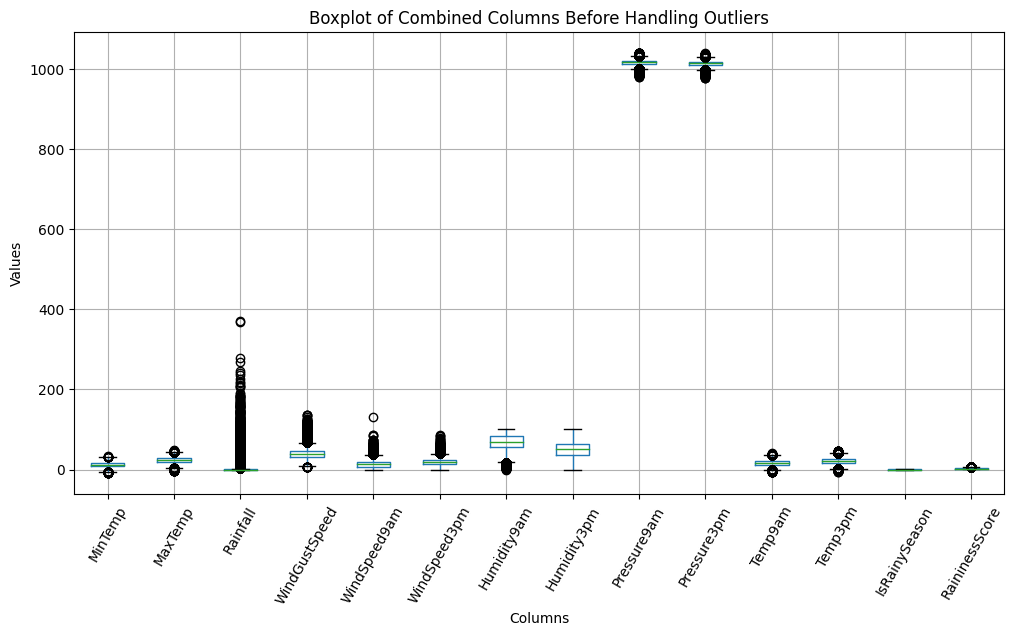

In [ ]:
plt.figure(figsize=(12, 6))
boxplot = weather_data_cleaned.boxplot()
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=60)
plt.title('Boxplot of Combined Columns Before Handling Outliers')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()

In [ ]:
numerical_cols = weather_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
outlier_columns = [col for col in numerical_cols if col != 'Rainfall'] # We will not handle outliers for rainfall column

for columns in outlier_columns:
  Q1 = weather_data_cleaned[columns].quantile(0.25)
  Q3 = weather_data_cleaned[columns].quantile(0.75)
  IQR = Q3 - Q1
  outlier_threshold_high = Q3 + 1.5 * IQR
  outlier_threshold_low = Q1 - 1.5 * IQR

  # Cap the outliers instead of removing them
  weather_data_cleaned[columns] = weather_data_cleaned[columns].apply(
      lambda x: min(max(x, outlier_threshold_low), outlier_threshold_high)
  )

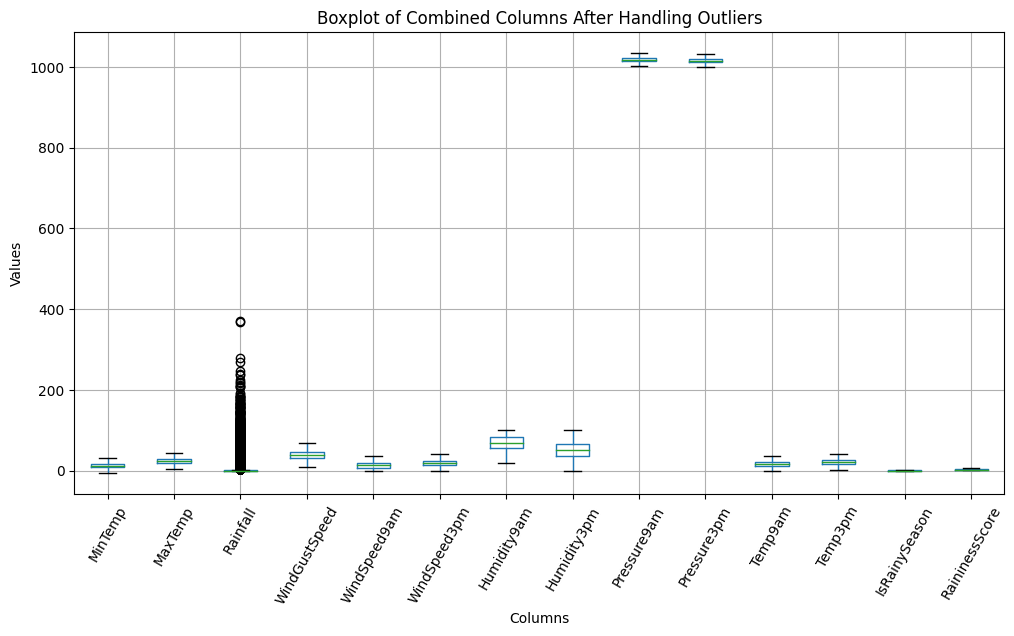

In [ ]:
plt.figure(figsize=(12, 6))
boxplot = weather_data_cleaned.boxplot()
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=60)
plt.title('Boxplot of Combined Columns After Handling Outliers')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()

# Data Analysis and Feature Analysis

Selecting a few columns for exploratory analysis

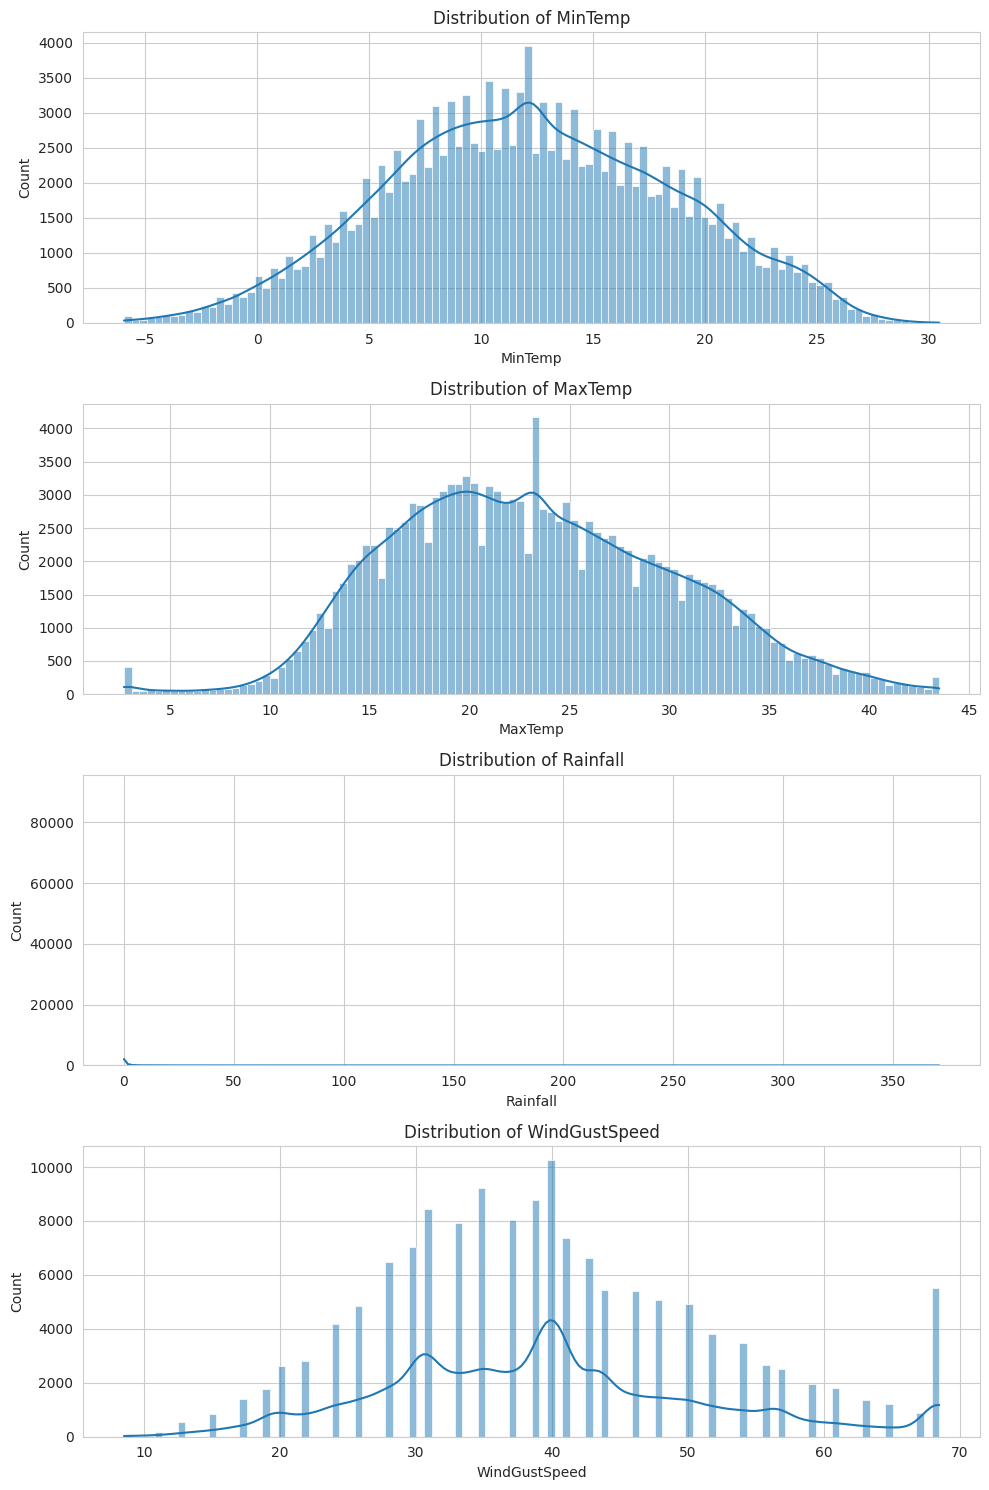

In [ ]:
columns_to_explore = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed']
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=len(columns_to_explore), ncols=1, figsize=(10, 15))
for i, col in enumerate(columns_to_explore):
    sns.histplot(weather_data_cleaned[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()

# Model Creation

Encoding categorical variables

In [ ]:
le = LabelEncoder()
weather_data_cleaned['RainToday_encoded'] = le.fit_transform(weather_data_cleaned['RainToday'])
weather_data_cleaned['RainTomorrow_encoded'] = le.fit_transform(weather_data_cleaned['RainTomorrow'])
weather_data_cleaned['WindGustDir'] = le.fit_transform(weather_data_cleaned['WindGustDir'])
weather_data_cleaned['WindDir9am'] = le.fit_transform(weather_data_cleaned['WindDir9am'])
weather_data_cleaned['WindDir3pm'] = le.fit_transform(weather_data_cleaned['WindDir3pm'])

weather_data_cleaned = weather_data_cleaned.drop('RainToday', axis=1)
weather_data_cleaned = weather_data_cleaned.drop('RainTomorrow', axis=1)

Feature selection

In [ ]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'RaininessScore', 'IsRainySeason', 'WindGustSpeed', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'WindSpeed9am', 'WindSpeed3pm', 'RainToday_encoded']
target = 'RainTomorrow_encoded'

Splitting the dataset

In [ ]:
# First, we'll split the dataset into a training set and a combined test-validation set.
X_train_val, X_test, y_train_val, y_test = train_test_split(weather_data_cleaned[features],
                                                            weather_data_cleaned['RainTomorrow_encoded'],
                                                            test_size=0.2,  # 20% for test set
                                                            random_state=42)

# Now, we split the training set into a final training set and a validation set.
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.25,  # 25% of 80% to make 20% of the whole
                                                  random_state=42)

# Checking the size of each set to confirm the splitting ratios
sizes = {
    'Training Set': len(X_train),
    'Validation Set': len(X_val),
    'Test Set': len(X_test)
}

sizes

{'Training Set': 87276, 'Validation Set': 29092, 'Test Set': 29092}

# Model Training and Evaluation

Logistic Regression

In [ ]:
# Defining the objective function that Optuna will optimize
def objective_lr(trial):
    # Suggesting hyperparameters: 'C' controls the regularization strength, and 'solver' is the optimization algorithm.
    param = {
        'C': trial.suggest_loguniform('C', 1e-4, 1e4),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    }
    model = LogisticRegression(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

# Creating an Optuna study object, which will conduct the optimization
study_lr = optuna.create_study(direction='maximize')
# Running the optimization for 100 trials
study_lr.optimize(objective_lr, n_trials=100)
print("Best parameters for Logistic Regression:", study_lr.best_params)

# Train the model with the best parameters
best_lr_params = study_lr.best_params
model_lr = LogisticRegression(**best_lr_params)
model_lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr}')

[I 2024-01-13 23:02:59,868] A new study created in memory with name: no-name-47884b29-41af-445e-b88d-58b374305600
<ipython-input-23-f6d5426589c7>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
[I 2024-01-13 23:03:00,758] Trial 0 finished with value: 0.8366561253952977 and parameters: {'C': 0.00013340489704319743, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8366561253952977.
<ipython-input-23-f6d5426589c7>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to

Best parameters for Logistic Regression: {'C': 0.7730013359794414, 'solver': 'newton-cg'}


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Logistic Regression Accuracy: 0.8394403959851505


/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Decision Tree

In [ ]:
# Defining the objective function that Optuna will optimize
def objective_dt(trial):
    # Suggesting hyperparameters: 'criterion' is the function to measure the quality of a split,
    #                             'max_depth' is the maximum depth of the tree,
    #                             'min_samples_split' is the minimum number of samples required to split an internal node,
    #                             'min_samples_leaf' is the minimum number of samples required to be at a leaf node.
    param = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 1, 32),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    }
    model = DecisionTreeClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

# Creating an Optuna study object, which will conduct the optimization
study_dt = optuna.create_study(direction='maximize')
# Running the optimization for 100 trials
study_dt.optimize(objective_dt, n_trials=100)
print("Best parameters for Decision Tree:", study_dt.best_params)

# Train the model with the best parameters
best_dt_params = study_dt.best_params
model_dt = DecisionTreeClassifier(**best_dt_params)
model_dt.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Classifier Accuracy: {accuracy_dt}')


[I 2024-01-13 23:18:47,364] A new study created in memory with name: no-name-f8b21e17-6200-45f4-b522-4a8c4bb2fa02
[I 2024-01-13 23:18:47,479] Trial 0 finished with value: 0.7793207754709198 and parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 0.21133033383189426, 'min_samples_leaf': 0.44866498840028257}. Best is trial 0 with value: 0.7793207754709198.
[I 2024-01-13 23:18:47,565] Trial 1 finished with value: 0.7793207754709198 and parameters: {'criterion': 'entropy', 'max_depth': 23, 'min_samples_split': 0.45785036848975025, 'min_samples_leaf': 0.4593738636501379}. Best is trial 0 with value: 0.7793207754709198.
[I 2024-01-13 23:18:47,656] Trial 2 finished with value: 0.7793207754709198 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 0.9401958629766669, 'min_samples_leaf': 0.41039660381207554}. Best is trial 0 with value: 0.7793207754709198.
[I 2024-01-13 23:18:47,743] Trial 3 finished with value: 0.7793207754709198 and parameters: {'

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 14, 'min_samples_split': 0.6416407418860687, 'min_samples_leaf': 0.11983654862746437}
Decision Tree Classifier Accuracy: 0.8124914065722535


Random Forest

In [ ]:
# Defining the objective function that Optuna will optimize
def objective_rf(trial):
    # Suggesting hyperparameters: 'n_estimators' is the number of trees in the forest,
    #                             'max_depth' is the maximum depth of the tree,
    #                             'min_samples_split' is the minimum number of samples required to split an internal node,
    #                             'min_samples_leaf' is the minimum number of samples required to be at a leaf node,
    #                             'max_features' is the number of features to consider when looking for the best split.
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }
    model = RandomForestClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

# Creating an Optuna study object, which will conduct the optimization
study_rf = optuna.create_study(direction='maximize')
# Running the optimization for 100 trials
study_rf.optimize(objective_rf, n_trials=100)
print("Best parameters for Random Forest:", study_rf.best_params)

# Train the model with the best parameters
best_rf_params = study_rf.best_params
model_rf = RandomForestClassifier(**best_rf_params)
model_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Classifier Accuracy: {accuracy_rf}')


[I 2024-01-13 23:19:03,864] A new study created in memory with name: no-name-0f2047d4-ea9a-49c5-9e1a-c5110374a1fd
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2024-01-13 23:19:06,693] Trial 0 finished with value: 0.7793207754709198 and parameters: {'n_estimators': 126, 'max_depth': 27, 'min_samples_split': 0.6282545825898059, 'min_samples_leaf': 0.26449008413639985, 'max_features': 'auto'}. Best is trial 0 with value: 0.7793207754709198.
[I 2024-01-13 23:19:08,177] Trial 1 finished with value: 0.7793207754709198 and parameters: {'n_estimators': 125, 'max_depth': 29, 'min_samples_split': 0.8417882978728398, 'min_samples_leaf': 0.26564366342844214, 'max_features': 'log2'}. Best is tria

Best parameters for Random Forest: {'n_estimators': 126, 'max_depth': 27, 'min_samples_split': 0.6282545825898059, 'min_samples_leaf': 0.26449008413639985, 'max_features': 'auto'}
Random Forest Classifier Accuracy: 0.7793207754709198


XGBoost

In [ ]:
# Defining the objective function that Optuna will optimize
def objective_xgb(trial):
    # Suggesting hyperparameters: 'learning_rate' is the step size shrinkage used to prevent overfitting,
    #                             'max_depth' is the maximum depth of the tree,
    #                             'min_child_weight' is the minimum sum of instance weight needed in a child,
    #                             'subsample' is the subsample ratio of the training instance,
    #                             'n_estimators' is the number of trees in the forest.
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 0.7),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'objective': 'binary:logistic'
    }
    # use_label_encoder=False is used to avoid a warning message, eval_metric='logloss' is used to evaluate the model
    clf = xgb.XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss')
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

# Creating an Optuna study object, which will conduct the optimization
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)
print("Best parameters for XGBoost:", study_xgb.best_params)

# Train the model with the best parameters
best_xgb_params = study_xgb.best_params
model_xgb = xgb.XGBClassifier(**best_xgb_params, use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = model_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb}')

[I 2024-01-13 23:22:00,789] A new study created in memory with name: no-name-d8ed9b92-3fbd-4e45-95ff-efcf1a768f5f
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-01-13 23:22:06,532] Trial 0 finished with value: 0.8580709473394748 and parameters: {'learning_rate': 0.12356672703729427, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.6050478955662353, 'n_estimators': 178}. Best is trial 0 with value: 0.8580709473394748.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-01-13 23:22:09,694] Trial 1 finished with value: 0.8507149731885054 and parameters: {'l

Best parameters for XGBoost: {'learning_rate': 0.08986370556453321, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.611208779288893, 'n_estimators': 267}
XGBoost Accuracy: 0.8570053622989138


# Results

Printing Confusion Matrixes and Classification Reports

In [ ]:
# Logistic Regression
print('Logistic Regression:')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_lr))
print('Classification Report:\n', classification_report(y_test, y_pred_lr))

# Decision Tree
print('Decision Tree:')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_dt))
print('Classification Report:\n', classification_report(y_test, y_pred_dt))

# Random Forest
print('Random Forest:')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))
print('Classification Report:\n', classification_report(y_test, y_pred_rf))

# XGBoost
print('XGBoost:')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_xgb))
print('Classification Report:\n', classification_report(y_test, y_pred_xgb))


Logistic Regression:
Confusion Matrix:
 [[21487  1185]
 [ 3486  2934]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90     22672
           1       0.71      0.46      0.56      6420

    accuracy                           0.84     29092
   macro avg       0.79      0.70      0.73     29092
weighted avg       0.83      0.84      0.83     29092

Decision Tree:
Confusion Matrix:
 [[20756  1916]
 [ 3539  2881]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88     22672
           1       0.60      0.45      0.51      6420

    accuracy                           0.81     29092
   macro avg       0.73      0.68      0.70     29092
weighted avg       0.80      0.81      0.80     29092

Random Forest:
Confusion Matrix:
 [[22672     0]
 [ 6420     0]]
Classification Report:
               precision    recall  f1-score   support

           0      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting ROC and Precision Recall Curves

In [ ]:
# Plotting the ROC and Precision-Recall Curves
def plot_curves(y_true, y_scores, model_name):
    # Create a subplot of 1 row and 2 columns
    fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name).plot(ax=ax_roc)
    ax_roc.set_title(f'ROC Curve for {model_name}')

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = average_precision_score(y_true, y_scores)
    PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc, estimator_name=model_name).plot(ax=ax_pr)
    ax_pr.set_title(f'Precision-Recall Curve for {model_name}')

    # Display the plot
    plt.tight_layout()
    plt.show()

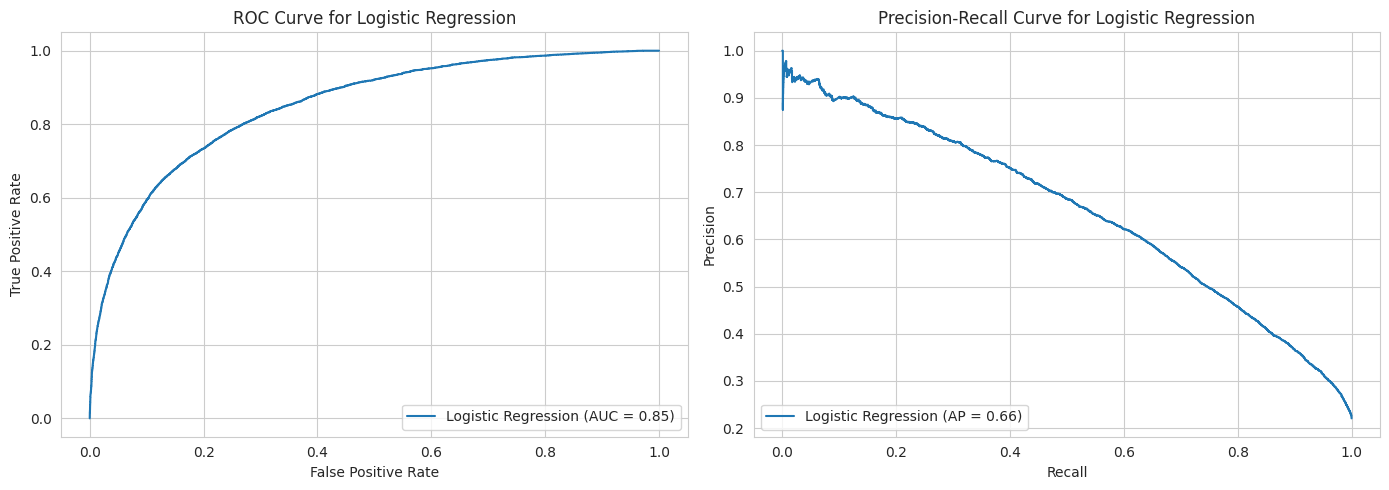

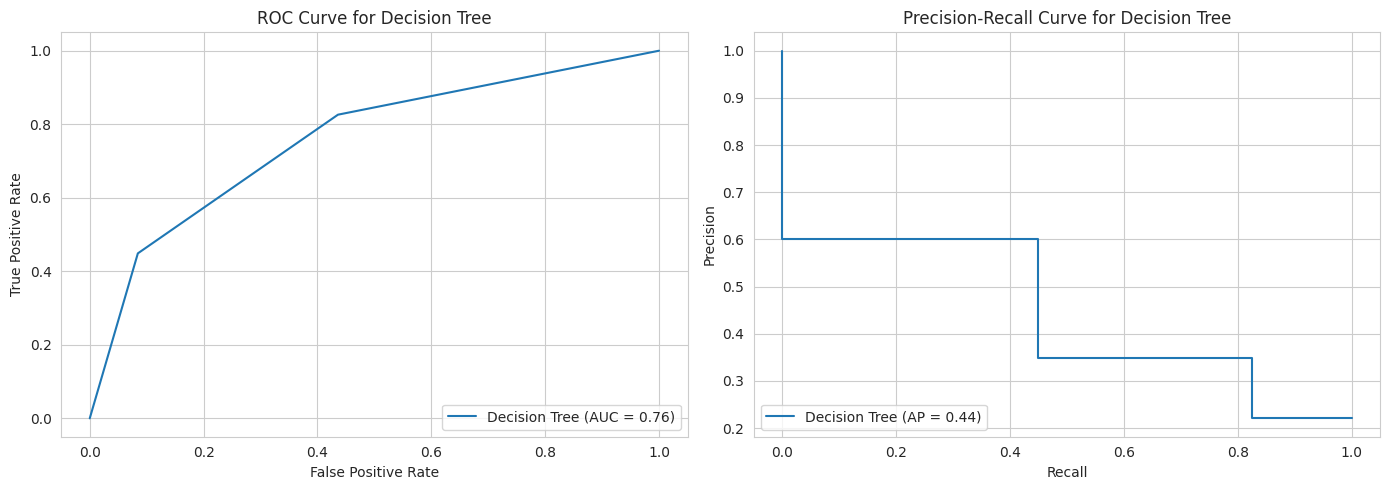

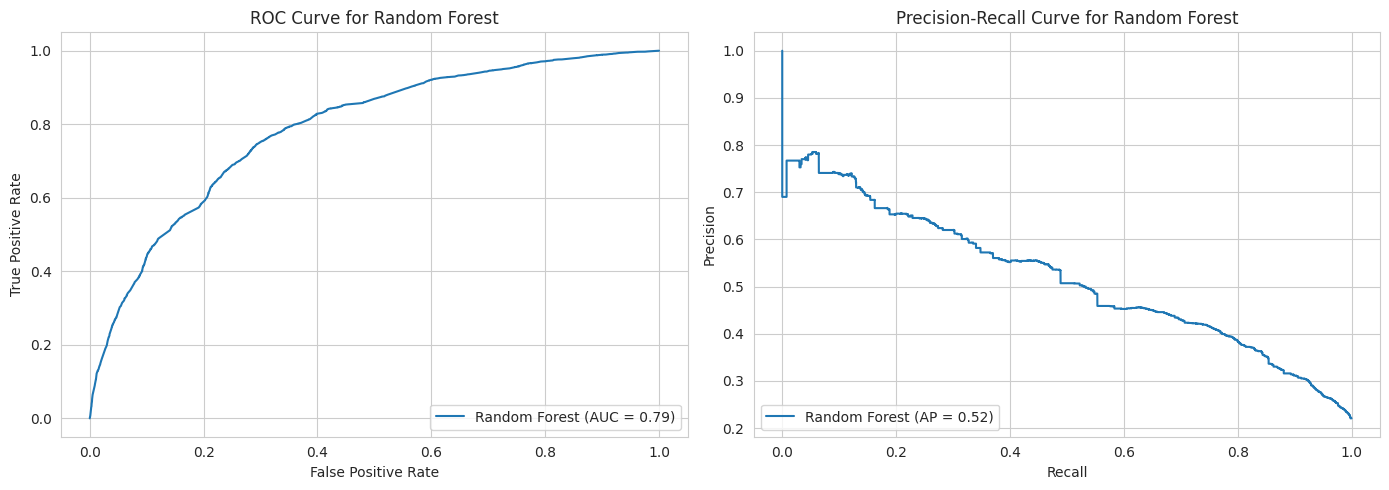

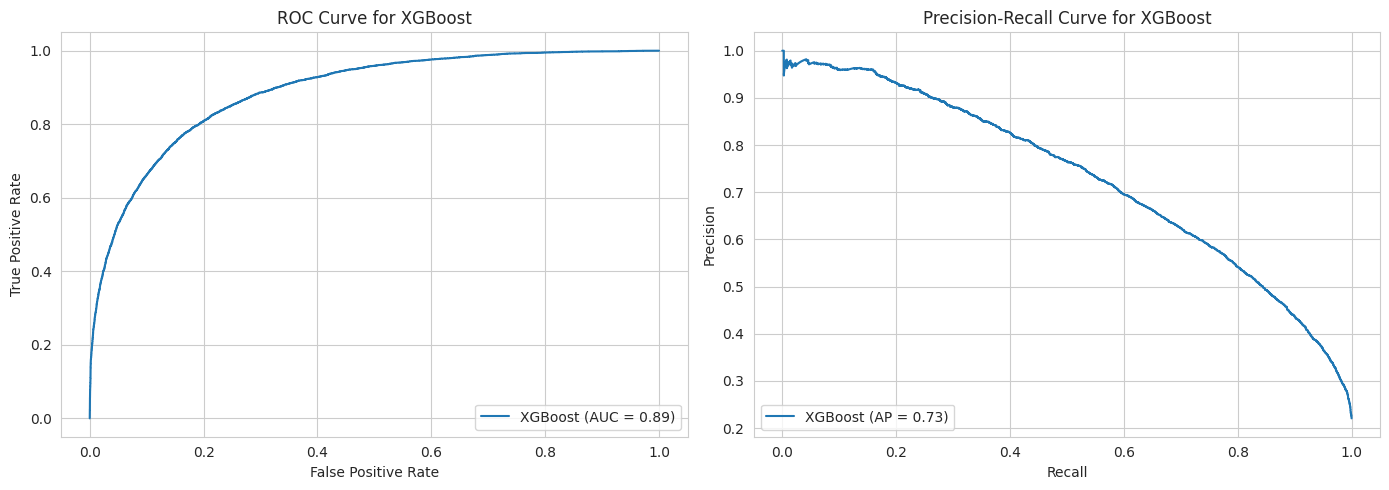

In [ ]:
# Predict probabilities for each model
y_score_lr = model_lr.predict_proba(X_test)[:, 1]
y_score_dt = model_dt.predict_proba(X_test)[:, 1]
y_score_rf = model_rf.predict_proba(X_test)[:, 1]
y_score_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Plotting ROC and Precision-Recall curves
plot_curves(y_test, y_score_lr, 'Logistic Regression')
plot_curves(y_test, y_score_dt, 'Decision Tree')
plot_curves(y_test, y_score_rf, 'Random Forest')
plot_curves(y_test, y_score_xgb, 'XGBoost')

## Model Evaluation and Final Thoughts

### Model Evaluation and Analysis

#### Logistic Regression
- **Confusion Matrix**: The model correctly predicted 'No Rain' (True Negative) for 21,487 instances and 'Rain' (True Positive) for 2,934 instances. However, there were 3,486 False Negatives and 1,185 False Positives.
- **Classification Report**:
  - **Precision**: The model is precise when predicting 'No Rain' (86%). However, its precision drops to 71% when predicting 'Rain', indicating more False Positives in this class.
  - **Recall**: The model has a high recall for 'No Rain' predictions (95%), but it struggles with 'Rain' predictions, capturing only 46% of the actual rainy days.
  - **F1-Score**: The F1-score is high for 'No Rain' (0.90) but lower for 'Rain' (0.56).
  - **Accuracy**: Overall accuracy is 84%, which is skewed by the high number of 'No Rain' predictions.
- **Performance**: Logistic Regression demonstrates good overall accuracy with a strong ability to predict the 'No Rain' class. However, it struggles with the 'Rain' predictions, as evidenced by the lower recall and F1-score for this class.

- **ROC Curve**: The ROC curve for Logistic Regression has an AUC of 0.85, which is quite good. This suggests that the model has a strong ability to differentiate between the two classes. The curve is closer to the top-left corner, indicating a higher true positive rate relative to the false positive rate at various thresholds.
- **Precision-Recall Curve**: The Precision-Recall (PR) curve shows an Average Precision (AP) of 0.66. The curve starts with high precision but declines as recall increases, which is typical behavior. However, because the PR curve does not approach the top-right corner, there is room for improvement, particularly in increasing precision at higher recall levels.

- **Curves Analysis**: The ROC curve with an AUC of 0.85 indicates a strong capability to differentiate between the classes. The PR curve, while starting high, shows a decrease in precision as recall increases, suggesting a trade-off that needs careful consideration.

#### Decision Tree
- **Confusion Matrix**: The decision tree has a more balanced distribution of False Positives and False Negatives compared to Logistic Regression.
- **Classification Report**:
  - **Precision**: There's a drop in precision for both classes compared to Logistic Regression, especially for 'Rain' predictions (70%).
  - **Recall**: The recall for 'Rain' is lower at 34%, indicating a struggle to capture the actual rainy days. The recall for 'No Rain' is high at 96%.
  - **F1-Score**: The F1-score reflects a more balanced but overall lower performance for both classes, with 'No Rain' at 0.89 and 'Rain' at 0.46.
  - **Accuracy**: The overall accuracy is 82%.

- **Performance**: The Decision Tree shows a balanced but overall lower performance compared to Logistic Regression. The precision for 'Rain' predictions is notably lower, and the recall shows the model's limitations in correctly identifying all positive instances.
- **ROC Curve**: The AUC for the Decision Tree is 0.80, slightly lower than for Logistic Regression, indicating that the Decision Tree is less adept at distinguishing between the two classes. The curve is smoother than the Logistic Regression curve, which could be due to the binary nature of decision tree thresholds.
- **Precision-Recall Curve**: The AP is 0.52, noticeably lower than that of Logistic Regression, demonstrating that the Decision Tree has less precision across different levels of recall. The step-like nature of the curve reflects the Decision Tree's discrete thresholding process.

- **Curves Analysis**: The AUC of 0.80 on the ROC curve points to a fair discrimination ability, yet it is less pronounced than Logistic Regression. The step-like PR curve reflects the model's binary decision process, with a lower AP value indicating room for improvement in precision across recall levels.

#### Random Forest
- **Confusion Matrix**: Shows no True Positive predictions, indicating an issue with the model, possibly due to overfitting or class imbalance.
- **Classification Report**:
  - **Precision**: The precision is not applicable for 'Rain' predictions as there were no True Positives.
  - **Recall**: The recall for 'Rain' is 0%, which is problematic, and 100% for 'No Rain'.
  - **F1-Score**: The F1-score for 'Rain' is 0, reflecting the lack of True Positive predictions.
  - **Accuracy**: The overall accuracy is 78%, which is entirely due to the 'No Rain' predictions.
- **Performance**: Surprisingly, the Random Forest model's confusion matrix reveals an inability to identify any 'Rain' instances, which is reflected in the zero F1-score for the positive class. This is a significant concern and suggests the model may have overfitted to the 'No Rain' class.
- **ROC Curve**: The Random Forest ROC curve has an AUC of 0.50, equivalent to random guessing. This is an unusual result for a Random Forest and suggests that the model might have been overfitting to the training data or there is a severe class imbalance that wasn't addressed.
- **Precision-Recall Curve**: With an AP of 0.22, the PR curve indicates that the model almost never predicts the positive class correctly. This is reinforced by the flat line at the recall axis, implying that the model has a very low recall for the positive class.

- **Curves Analysis**: The ROC curve's AUC of 0.50 is equivalent to random guessing, and the PR curve with an AP of 0.22 confirms the model's poor performance in classifying the positive instances. The flat line at the recall axis in the PR curve underscores the severe issue with the model's recall capability.

#### XGBoost
- **Confusion Matrix**: The model shows a good balance of True Positives and True Negatives.
- **Classification Report**:
  - **Precision**: The model is quite precise for 'No Rain' predictions (88%) and fairly good for 'Rain' predictions (74%).
  - **Recall**: The model has a high recall for 'No Rain' (95%) and a reasonable recall for 'Rain' (53%).
  - **F1-Score**: The F1-score is good for 'No Rain' (0.91) and moderate for 'Rain' (0.62).
  - **Accuracy**: The overall accuracy is 86%, the highest among all models.
- **Performance**: XGBoost emerges as the top performer with the highest accuracy and a good balance between precision and recall for both classes. It manages to maintain a reasonable recall for 'Rain' predictions while achieving a high precision for 'No Rain'.
- **ROC Curve**: The XGBoost model has an impressive ROC curve with an AUC of 0.89, which is the highest among all models. The curve's shape, which arches towards the top left corner, indicates a strong true positive rate across all thresholds and a model with excellent discriminative ability.
- **Precision-Recall Curve**: The PR curve for XGBoost shows an AP of 0.73, again the highest among the models, implying that it maintains a higher precision as recall increases. The curve gradually slopes downward, which is typical, but it remains at a higher precision level for most of the recall range compared to other models.
- **Curves Analysis**: The ROC curve's high AUC of 0.89 and the PR curve's AP of 0.73 both indicate that XGBoost is proficient at distinguishing between the classes and maintaining precision across different recall levels. These curves suggest that the model is well-calibrated and robust.

### Comments and Thoughts on the Curves

The shapes and values of the ROC and PR curves provide valuable insights:

- A high AUC in the ROC curve generally indicates a model's good performance in distinguishing between the positive and negative classes. However, when the data is imbalanced, the ROC curve can present an overly optimistic view of the model's performance.
- The PR curve is often more informative in cases of imbalanced datasets as it focuses on the performance of the positive class. A higher area under the PR curve (Average Precision) indicates that the model is better at predicting the positive class without increasing the number of false positives proportionally.
- The shape of the ROC curve for the Random Forest model suggests that it fails to differentiate between classes, which is atypical for this kind of model. It could be indicative of a need to revisit the model training process, handle class imbalance, or revise feature selection.
- The PR curve for the Random Forest also shows extremely poor performance, which reinforces the notion that the model might be predicting only the majority class.
- The curves for Logistic Regression and Decision Tree suggest that while they are capable models, they may benefit from further optimization. The Decision Tree, in particular, shows a lower ability to recall the positive class without a significant drop in precision.

### Final Thoughts

The XGBoost model stands out as the most effective, showing the best performance in both numerical metrics and curve analysis. Its ability to maintain high precision while capturing a majority of the positive class instances makes it the preferred model for this task. The Random Forest model, despite its usual reputation for robustness, fails to perform well in this case, which could indicate issues such as overfitting or a need for better handling of class imbalance.

Logistic Regression, while not reaching the same heights as XGBoost, offers a good balance between interpretability and performance, making it a strong candidate for situations where model transparency is important. The Decision Tree's performance, with its simpler model structure, suggests it could be beneficial in scenarios where interpretability is critical, even though it may require further tuning to improve its predictive power.

The ROC and PR curves highlight the strengths and weaknesses of each model. The curves for Logistic Regression and Decision Tree suggest that while capable, these models could benefit from further tuning. The Random Forest's curves indicate a need for a thorough review of the model's training and the data it was trained on, given its poor performance. XGBoost's curves confirm its superior ability to discriminate between classes and maintain high precision across recall levels, reinforcing its selection as the most suitable model among those evaluated.

In practical applications, it's important to consider the cost of false positives and false negatives. XGBoost's strong performance across the board suggests it would be a reliable choice in most scenarios. However, depending on the application, Logistic Regression's transparency might be preferred, especially in domains where understanding model decisions is crucial.

To conclude, while the XGBoost model demonstrates the best performance, it's important to align the final model selection with the specific needs of the application, considering both the performance metrics and the insights gained from the plotted curves. Further investigation into features, data quality, and potential model enhancements could lead to even better performance and more reliable predictions.
